In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
np.random.seed(42)

species_of_interest = ["@H2SIO", "H", "H2", "O", "C", "N", "CL", "E-", "CO", "MG", "#C", "H2O", "SI", 'SURFACE', 'BULK', 'C+']
physical_params = ['density', 'gasTemp', 'av', 'radField']

In [78]:
x = os.listdir('data/chemistry_tracers_csv/')
y = []
for file in x:
    if file == "M600_1_1_Tracer_10_.csv":
        continue
    y.append(int(file.replace('M600_1_1_Tracer_', '').replace('.csv', '')))

indices = list(sorted(set(y)))
print(indices)

[216, 2585, 2761, 2767, 3619, 4548, 5712, 8270, 8814, 9060, 9266, 9712, 10063, 10151, 11812, 13396, 14182, 15125, 15180, 18853, 19592, 19993, 20090, 21681, 21925, 23667, 25386, 26445, 26506, 29110, 30803, 35540, 37453, 37600, 39494, 40355]


In [2]:
indices = [26506]

In [3]:
results = {}
file_scores = []
files_summary = []

for ind in indices:
    try:
        df = pd.read_csv(f"data/chemistry_tracers_csv/M600_1_1_Tracer_{ind}.csv")

        stiffness = {
            col: np.log10(df[col][df[col] > 0]).clip(lower=-20).diff().abs().mean()
            for col in df.select_dtypes(include=[np.number]).columns
        }
        results[ind] = stiffness

        file_score = np.mean([val for val in stiffness.values() if val is not None])
        file_scores.append((ind, file_score))

        top5_species = sorted(
            stiffness.items(),
            key=lambda x: x[1] if x[1] is not None else -np.inf,
            reverse=True
        )[:5]

        files_summary.append({
            "ind": ind,
            "species": [col for col, _ in top5_species],
            "values": [val for _, val in top5_species],
            "score": file_score
        })

    except Exception as e:
        print(f"Error reading file {ind}: {e}")

files_summary = sorted(files_summary, key=lambda x: x["score"], reverse=True)

print("\nFiles ranked by overall stiffness:")
for file in files_summary:
    print(f"\nFile {file['ind']}: Overall stiffness {file['score']:.4f}")
    for col, val in zip(file["species"], file["values"]):
        print(f"  {col}: {val:.4f}")



Files ranked by overall stiffness:

File 26506: Overall stiffness 0.0428
  BULK: 0.5129
  @C: 0.4916
  @C2: 0.1599
  CH3CCH: 0.1325
  #C: 0.1303


Current tracer index: 26506


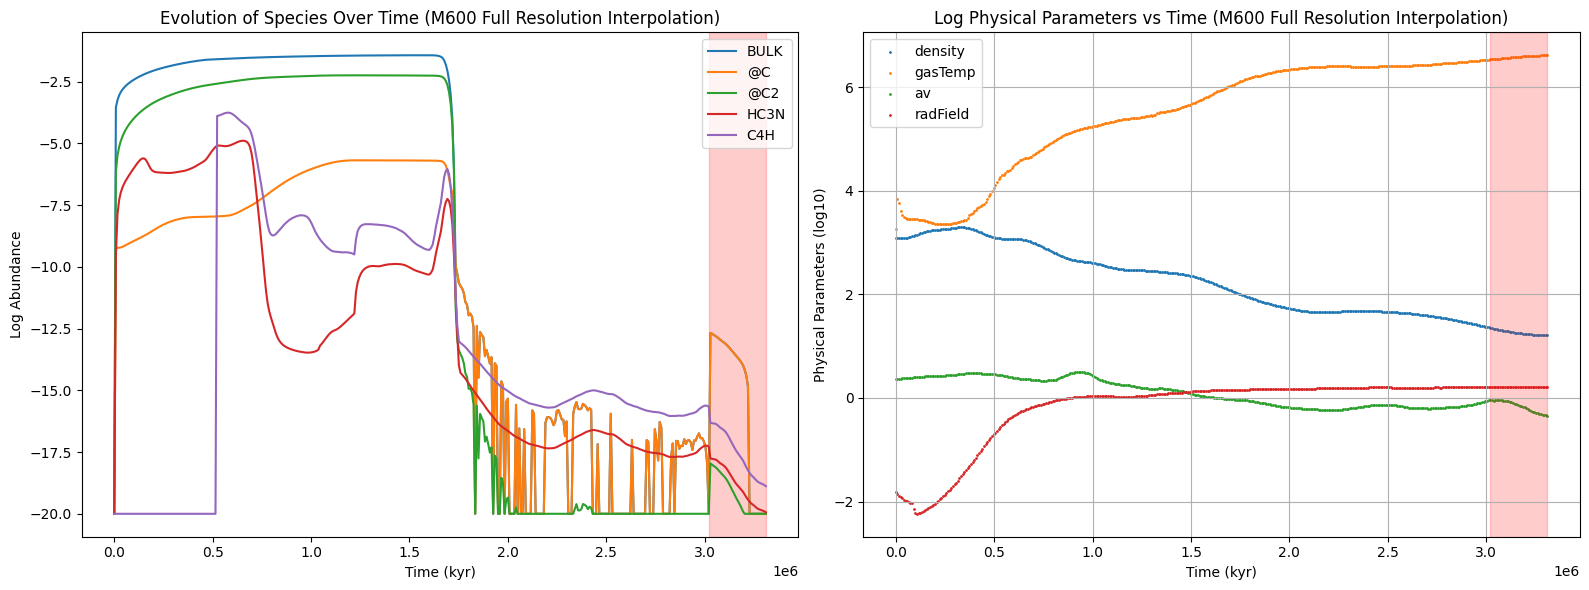

In [4]:
file_idx = 0
species_of_interest = files_summary[file_idx]["species"]
print(f'Current tracer index: {files_summary[file_idx]["ind"]}')
df = pd.read_csv(f'data/chemistry_tracers_csv/M600_1_1_Tracer_{files_summary[file_idx]["ind"]}.csv')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

species_of_interest = ['BULK', '@C', '@C2', 'HC3N', 'C4H']
for species in species_of_interest:
    if species in df.columns:
        log_abundance = np.log10(df[species].replace(0, np.nan))
        log_abundance = np.maximum(log_abundance, -20)
        ax1.plot(df['time'], log_abundance, label=species)

ax1.set_xlabel('Time (kyr)')
ax1.set_ylabel('Log Abundance')
ax1.set_title('Evolution of Species Over Time (M600 Full Resolution Interpolation)')
ax1.legend()

for param in physical_params:
    if param in df.columns:
        y = pd.to_numeric(np.log10(df[param]), errors='coerce')
        if param == 'gasTemp':
            y*=3
        ax2.scatter(df['time'], y, label=param, s=1)
        
if "gasTemp" in df.columns:
    above = df["gasTemp"] > 150
    regions = []
    in_region = False
    start = None
    for i in range(len(df)):
        if above.iloc[i] and not in_region:
            start = df["time"].iloc[i]
            in_region = True
        elif not above.iloc[i] and in_region:
            end = df["time"].iloc[i]
            regions.append((start, end))
            in_region = False
    if in_region:
        regions.append((start, df["time"].iloc[-1]))

    for start, end in regions:
        ax1.axvspan(start, end, color="red", alpha=0.2)
        ax2.axvspan(start, end, color="red", alpha=0.2)
    
ax2.set_xlabel('Time (kyr)')
ax2.set_ylabel('Physical Parameters (log10)')
ax2.set_title('Log Physical Parameters vs Time (M600 Full Resolution Interpolation)')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()

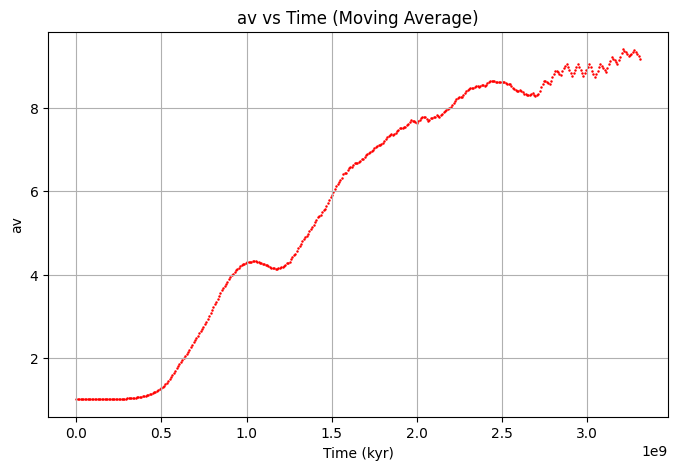

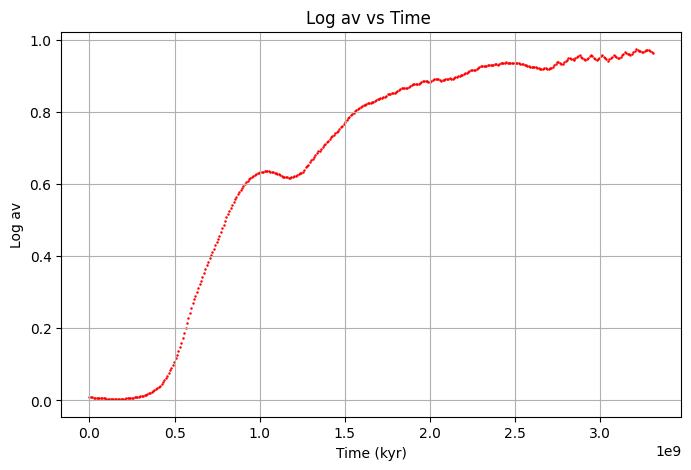

In [123]:
df1 = pd.read_csv(f'data/chemistry_tracers_csv/M600_1_1_Tracer_26506.csv')

param = 'av'

plt.figure(figsize=(8, 5))
plt.scatter(1000*df1['time'], (df1[param].clip(lower=1e-30)), color='red', s=0.6)
plt.xlabel("Time (kyr)")
plt.ylabel(f"{param}")
plt.title(f"{param} vs Time (Moving Average)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.scatter(1000*df1['time'], np.log10(df1[param].clip(lower=1e-30)), color='red', s=0.6)
plt.xlabel("Time (kyr)")
plt.ylabel(f"Log {param}")
plt.title(f"Log {param} vs Time ")
plt.grid(True)
plt.show()